<a href="https://colab.research.google.com/github/ShlomiHemo/CostManager/blob/main/Pneumonia_Final_Project_3Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print("Listing files and directories from the current location:")
list_files('.')

Listing files and directories from the current location:
./
    .config/
        .last_survey_prompt.yaml
        .last_opt_in_prompt.yaml
        gce
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        config_sentinel
        .last_update_check.json
        default_configs.db
        active_config
        logs/
            2025.11.04/
                14.36.48.366421.log
                14.36.49.228321.log
                14.36.00.268750.log
                14.36.23.552106.log
                14.36.35.041542.log
                14.36.36.425624.log
        configurations/
            config_default
    sample_data/
        README.md
        anscombe.json
        california_housing_test.csv
        mnist_test.csv
        california_housing_train.csv
        mnist_train_small.csv


In [ ]:
import nbformat
import shutil

# Backup original
shutil.copy('Pneumonia_Final_Project_3Models.ipynb', 'Pneumonia_Final_Project_3Models_backup.ipynb')

# Load notebook
with open('Pneumonia_Final_Project_3Models.ipynb', 'r') as f:
    nb = nbformat.read(f, as_version=4)

# Remove problematic widgets metadata (keeps all outputs!)
if 'widgets' in nb.metadata:
    del nb.metadata['widgets']
    print("✓ Removed widget metadata")
else:
    print("✓ No widget metadata found")

# Save fixed version
with open('yPneumonia_Final_Project_3Models.ipynb', 'w') as f:
    nbformat.write(nb, f)

print("✓ Fixed! All outputs preserved. Backup saved as 'your_notebook_backup.ipynb'")

FileNotFoundError: [Errno 2] No such file or directory: 'Pneumonia_Final_Project_3Models.ipynb'

In [ ]:
# Import required libraries
!pip install -U -q gdown
!pip install -U -q PyDrive
import gdown
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision import models
from transformers import ViTForImageClassification, ViTConfig
from PIL import Image
import os
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2

### Comprehensive Data Preprocessing for Lung Image Analysis
## Database Overview

1. **!kaggle datasets download -d alexandrelemercier/60k-augmented-chest-x-ray-pneumonia**

2. **!kaggle datasets download paultimothymooney/chest-xray-pneumonia**

## Detailed EDA Findings from Database #1

Our thorough Exploratory Data Analysis of the first database revealed critical issues that needed addressing before model training:

1. **Improper Data Distribution**: The original train-test split was significantly imbalanced, which would have led to biased model training and unreliable evaluation metrics. This imbalance would have caused the model to favor the overrepresented class.

2. **Severe Class Imbalance**: We identified a substantial disproportion between pneumonia and healthy lung images. This imbalance would have caused the model to develop a strong bias toward the majority class (pneumonia), potentially resulting in high sensitivity but poor specificity.

3. **Data Redundancy**: Our analysis uncovered 450 duplicate images stored in different file formats (jpeg and jpg). These duplicates would have artificially inflated validation metrics and potentially caused data leakage between training and testing sets.

4. **File Format Inconsistency**: After extensive research into image quality preservation and computational efficiency, we determined that PNG is the optimal format for our analysis. PNG offers lossless compression, preserving subtle features that might be critical for pneumonia detection, while maintaining reasonable file sizes.

5. **Dimensional Variance**: Images in the dataset had inconsistent dimensions, which would have created processing irregularities during model training. Standardization to 256 × 256 pixels was determined to be the optimal resolution to balance detail preservation with computational efficiency.

<div style="display: flex; flex-direction: column; gap: 20px;">
  <img src="https://drive.google.com/uc?id=1OcmYMLleAzL4kRfUJeFDahvxNkiiusxy" alt="alt_text_1" style="width: 600px;" />
  <img src="https://drive.google.com/uc?id=1QDVbfZwJ--5JWqX8QZe07eslGZVhvvZj" alt="alt_text_2" style="width: 600px;" />
  <img src="https://drive.google.com/uc?id=1AUwbpptHl9UBhovCKURoyO0BRLixaccV" alt="alt_text_3" style="width: 600px;" />
  <img src="https://drive.google.com/uc?id=1EKS1Yf0jP0gytvBY17yEdhkf148nrKXb" alt="alt_text_4" style="width: 600px;" />
</div>

## Database #2 Enhancement Strategy

To address the class imbalance issue, we implemented a comprehensive augmentation protocol:

1. **Selective Sampling**: We isolated 1,540 healthy lung images from the second database to focus our augmentation efforts.

2. **Advanced Augmentation Techniques**: We applied multiple transformation methods including:
   - Rotation (±15 degrees)
   - Horizontal flips
   - Controlled brightness and contrast adjustments
   - Minimal zoom variations (±5%)
   - Slight shearing transformations

3. **Quality Control Process**: Each augmented image was verified to ensure it maintained anatomical plausibility and diagnostic relevance.

4. **Expansion Magnitude**: Through this systematic augmentation process, we successfully expanded our healthy lung image collection from 1,540 to approximately 20,000 images, all standardized to 256 × 256 pixels.

## Database Integration and Partitioning

After preprocessing both databases, we implemented a sophisticated integration and partitioning strategy:

1. **Database Merger**: We carefully combined the preprocessed images from both sources, ensuring no duplicates or corrupted files were included.

2. **Strategic Partitioning**: The combined dataset was divided into training (80%) and testing (20%) sets using stratified sampling to maintain class distribution.

3. **Balance Optimization**: Within each partition, we meticulously adjusted the ratio between healthy and pneumonia-affected lung images to approach 1:1, preventing class-based learning bias.

4. **Cross-Validation Preparation**: The training set was further organized to facilitate 5-fold cross-validation during model development, ensuring robust performance evaluation.

5. **Data Normalization**: All images underwent pixel value normalization to the range [0,1], enhancing gradient-based optimization during model training.

This comprehensive preprocessing pipeline ensured our data was optimally prepared for model training, addressing all identified issues while preserving data integrity and clinical relevance.

In [ ]:
# Data extraction and downloading
extract_path = '/content/my_data'

if not os.path.exists(extract_path):
    print("Data not found. Downloading and extracting...")
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    file_id = '14rw5tu5IORKIj8L6EwNcbKNmhINLRkzk'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('my_data.zip')

    with zipfile.ZipFile('my_data.zip', 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("File downloaded and extracted successfully.")
else:
    print("Data already exists. Skipping download.")

Data not found. Downloading and extracting...
File downloaded and extracted successfully.


In [ ]:
# Device configuration and constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
BATCH_SIZE = 32

Using device: cuda


# Data Preparation and Loading

## Image Transformations and Dataset Setup

The data preparation pipeline includes:

1. **Image Transformations**: Convert images to tensors and normalize using ImageNet statistics for transfer learning compatibility
2. **Dataset Splitting**: 80% training, 20% validation split with stratification to maintain class balance
3. **Data Loaders**: Efficient batch loading with multi-processing and memory pinning for optimal performance

This setup ensures consistent preprocessing across all three models and maintains reproducible results.

In [ ]:
# Dataset paths and transformations
train_data_path = '/content/my_data/train'
test_data_path = '/content/my_data/test'

# Image transformations - using ImageNet normalization for transfer learning compatibility
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
full_train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)

# Split training data into train and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(full_train_dataset))),
    test_size=0.2,
    stratify=full_train_dataset.targets,
    random_state=42
)

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("Dataset sizes:")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Dataset sizes:
Train samples: 53356
Validation samples: 13339
Test samples: 16674


# Early Stopping Utility Class

This reusable early stopping implementation monitors validation loss and prevents overfitting by terminating training when the model stops improving. The class tracks the best validation loss and implements patience-based stopping criteria.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, restore_best_weights=True):
        """
        Early stopping utility to prevent overfitting.

        Args:
            patience (int): Number of epochs to wait for improvement before stopping
            min_delta (float): Minimum change to qualify as an improvement
            restore_best_weights (bool): Whether to restore model to best weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        """
        Check if training should be stopped.

        Args:
            val_loss (float): Current validation loss
            model: PyTorch model

        Returns:
            bool: True if training should be stopped
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

    def restore_weights(self, model):
        """Restore the best weights to the model."""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

# Model Architectures

## 1. Custom CNN Model for Lung Image Analysis

This custom-designed CNN model processes 256x256 chest X-ray images through three convolutional blocks with batch normalization, dropout, and max pooling. The architecture is specifically tailored for binary pneumonia classification.

**Architecture Details:**
- Three convolutional blocks with increasing feature maps (16 → 32 → 64)
- Batch normalization and dropout for regularization
- Two fully connected layers for final classification
- Sigmoid activation for binary output probability

In [ ]:
class LungCNN(nn.Module):
    def __init__(self):
        super(LungCNN, self).__init__()

        # Block One
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.2)

        # Block Two
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.2)

        # Block Three
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.4)

        # Calculate flattened size for 256x256 input images
        self.flatten_size = 29 * 29 * 64

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Block One
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(self.pool1(x))

        # Block Two
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(self.pool2(x))

        # Block Three
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.relu(self.bn3(x))
        x = self.dropout3(self.pool3(x))

        # Fully connected layers
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = torch.sigmoid(self.fc2(x))

        return x

## 2. ResNet50 Transfer Learning Model

This implementation uses a pre-trained ResNet50 backbone with a custom classification head for pneumonia detection. The model leverages transfer learning from ImageNet to improve performance on medical imaging tasks.

**Key Features:**
- Pre-trained ResNet50 backbone for robust feature extraction
- Custom multi-layer classification head with dropout
- Lower learning rate to preserve pre-trained features

In [ ]:
class ResNet50ForLungClassification(nn.Module):
    def __init__(self, pretrained=True, freeze_backbone=False):
        super(ResNet50ForLungClassification, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=pretrained)

        # Optionally freeze backbone parameters
        if freeze_backbone:
            for param in self.resnet.parameters():
                param.requires_grad = False

        # Replace final layer with custom classification head
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

## 3. Vision Transformer (ViT) Model

This implementation uses a pre-trained Vision Transformer model adapted for binary pneumonia classification. ViTs process images as sequences of patches and use self-attention mechanisms for feature learning.

**Architecture Highlights:**
- Pre-trained ViT-base model from Hugging Face transformers
- Image resizing to 224x224 for ViT compatibility
- Custom classification head with dropout and sigmoid activation

In [ ]:
class SimpleViT(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pre-trained ViT model
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=1,
            ignore_mismatched_sizes=True
        )

        # Replace classifier for binary classification
        self.vit.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Resize images to 224x224 for ViT compatibility
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        outputs = self.vit(x)
        return outputs.logits

# Training and Evaluation Functions

These utility functions handle the training loop, validation, testing, and visualization for all three models. The modular design allows consistent evaluation across different architectures.

In [ ]:
def train_model(model, model_name, train_loader, val_loader, num_epochs=50, lr=0.001, patience=3):
    """
    Train a model with early stopping and return training history.

    Args:
        model: PyTorch model to train
        model_name: String name for the model (for printing)
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Maximum number of epochs
        lr: Learning rate
        patience: Early stopping patience

    Returns:
        dict: Training history containing losses and accuracies
    """
    criterion = nn.BCELoss()

    # Use different optimizers based on model type
    if 'ViT' in model_name:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=patience)

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    print(f"\nStarting {model_name} training for {num_epochs} epochs...")
    print(f"Total batches per epoch: {len(train_loader)}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        progress_bar = tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            current_loss = running_loss / (batch_idx + 1)
            current_acc = 100 * correct_predictions / total_samples
            progress_bar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_predictions / total_samples
        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Store history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print(f'Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"Best validation loss: {early_stopping.best_loss:.4f}")
            early_stopping.restore_weights(model)
            break

        print('-' * 60)

    print(f"{model_name} training completed!")
    return history

def evaluate_model(model, test_loader, model_name):
    """
    Evaluate model on test set and return comprehensive metrics.

    Args:
        model: Trained PyTorch model
        test_loader: Test data loader
        model_name: String name for the model

    Returns:
        dict: Dictionary containing test metrics
    """
    model.eval()
    criterion = nn.BCELoss()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        test_progress = tqdm(test_loader, desc=f'Testing {model_name}')
        for images, labels in test_progress:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            test_loss += loss.item()
            predicted = (outputs > 0.5).float().squeeze()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    all_preds = [1 if pred > 0.5 else 0 for pred in all_preds]
    test_accuracy = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)

    # Calculate detailed metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    cm = confusion_matrix(all_labels, all_preds)

    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }

    print(f'\n{model_name} Test Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return metrics

def plot_training_history(history, model_name):
    """Plot training and validation metrics."""
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='#3498db', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='#3498db', linewidth=2)
    plt.plot(history['val_acc'], label='Validation Accuracy', color='#e74c3c', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name}: Training and Validation Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix for a model."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(precision, recall, f1, model_name):
    """Plot precision, recall, and F1-score for a model."""
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    x = np.arange(2)

    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='#3498db')
    plt.bar(x, recall, width=bar_width, label='Recall', color='#2ecc71')
    plt.bar(x + bar_width, f1, width=bar_width, label='F1-Score', color='#e74c3c')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title(f'{model_name}: Precision, Recall, and F1-Score by Class')
    plt.xticks(x, ['NORMAL', 'PNEUMONIA'])
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    for i, metric in enumerate([precision, recall, f1]):
        for j, val in enumerate(metric):
            plt.text(j + (i-1)*bar_width, val + 0.02, f'{val:.2f}',
                     ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Model Training and Evaluation

## Training All Three Models

We now train and evaluate all three models using identical training procedures for fair comparison. Each model uses optimized hyperparameters and early stopping to prevent overfitting.

INITIALIZING ALL MODELS
Custom CNN - Total parameters: 3,505,601


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


ResNet50 - Total parameters: 24,049,089


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT - Total parameters: 85,995,777

TRAINING Custom CNN

Starting Custom CNN training for 50 epochs...
Total batches per epoch: 1668


Custom CNN Epoch 1/50: 100%|██████████| 1668/1668 [00:54<00:00, 30.72it/s, Loss=0.5243, Acc=73.17%]


Epoch [1/50]
Train - Loss: 0.5243, Accuracy: 73.17%
Val   - Loss: 0.2996, Accuracy: 86.63%
------------------------------------------------------------


Custom CNN Epoch 2/50: 100%|██████████| 1668/1668 [00:52<00:00, 31.89it/s, Loss=0.3988, Acc=80.10%]


Epoch [2/50]
Train - Loss: 0.3988, Accuracy: 80.10%
Val   - Loss: 0.2537, Accuracy: 88.81%
------------------------------------------------------------


Custom CNN Epoch 3/50: 100%|██████████| 1668/1668 [00:51<00:00, 32.14it/s, Loss=0.3653, Acc=81.68%]


Epoch [3/50]
Train - Loss: 0.3653, Accuracy: 81.68%
Val   - Loss: 0.2174, Accuracy: 90.83%
------------------------------------------------------------


Custom CNN Epoch 4/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.85it/s, Loss=0.3301, Acc=83.49%]


Epoch [4/50]
Train - Loss: 0.3301, Accuracy: 83.49%
Val   - Loss: 0.2071, Accuracy: 91.20%
------------------------------------------------------------


Custom CNN Epoch 5/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.09it/s, Loss=0.2975, Acc=85.79%]


Epoch [5/50]
Train - Loss: 0.2975, Accuracy: 85.79%
Val   - Loss: 0.1999, Accuracy: 91.03%
------------------------------------------------------------


Custom CNN Epoch 6/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.76it/s, Loss=0.2694, Acc=86.90%]


Epoch [6/50]
Train - Loss: 0.2694, Accuracy: 86.90%
Val   - Loss: 0.1857, Accuracy: 92.98%
------------------------------------------------------------


Custom CNN Epoch 7/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.97it/s, Loss=0.2546, Acc=88.06%]


Epoch [7/50]
Train - Loss: 0.2546, Accuracy: 88.06%
Val   - Loss: 0.1733, Accuracy: 93.52%
------------------------------------------------------------


Custom CNN Epoch 8/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.04it/s, Loss=0.2402, Acc=89.78%]


Epoch [8/50]
Train - Loss: 0.2402, Accuracy: 89.78%
Val   - Loss: 0.1708, Accuracy: 93.51%
------------------------------------------------------------


Custom CNN Epoch 9/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.17it/s, Loss=0.2306, Acc=90.55%]


Epoch [9/50]
Train - Loss: 0.2306, Accuracy: 90.55%
Val   - Loss: 0.1575, Accuracy: 93.85%
------------------------------------------------------------


Custom CNN Epoch 10/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.02it/s, Loss=0.2157, Acc=91.29%]


Epoch [10/50]
Train - Loss: 0.2157, Accuracy: 91.29%
Val   - Loss: 0.1494, Accuracy: 93.98%
------------------------------------------------------------


Custom CNN Epoch 11/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.01it/s, Loss=0.2049, Acc=91.95%]


Epoch [11/50]
Train - Loss: 0.2049, Accuracy: 91.95%
Val   - Loss: 0.1497, Accuracy: 93.99%
------------------------------------------------------------


Custom CNN Epoch 12/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.10it/s, Loss=0.1986, Acc=92.20%]


Epoch [12/50]
Train - Loss: 0.1986, Accuracy: 92.20%
Val   - Loss: 0.1478, Accuracy: 94.07%
------------------------------------------------------------


Custom CNN Epoch 13/50: 100%|██████████| 1668/1668 [00:51<00:00, 32.62it/s, Loss=0.1836, Acc=92.72%]


Epoch [13/50]
Train - Loss: 0.1836, Accuracy: 92.72%
Val   - Loss: 0.1479, Accuracy: 93.82%
------------------------------------------------------------


Custom CNN Epoch 14/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.94it/s, Loss=0.1841, Acc=92.78%]


Epoch [14/50]
Train - Loss: 0.1841, Accuracy: 92.78%
Val   - Loss: 0.1465, Accuracy: 93.69%
------------------------------------------------------------


Custom CNN Epoch 15/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.98it/s, Loss=0.1725, Acc=93.22%]


Epoch [15/50]
Train - Loss: 0.1725, Accuracy: 93.22%
Val   - Loss: 0.1400, Accuracy: 94.55%
------------------------------------------------------------


Custom CNN Epoch 16/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.75it/s, Loss=0.1639, Acc=93.46%]


Epoch [16/50]
Train - Loss: 0.1639, Accuracy: 93.46%
Val   - Loss: 0.1374, Accuracy: 94.35%
------------------------------------------------------------


Custom CNN Epoch 17/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.20it/s, Loss=0.1640, Acc=93.63%]


Epoch [17/50]
Train - Loss: 0.1640, Accuracy: 93.63%
Val   - Loss: 0.1370, Accuracy: 94.60%
------------------------------------------------------------


Custom CNN Epoch 18/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.19it/s, Loss=0.1599, Acc=93.89%]


Epoch [18/50]
Train - Loss: 0.1599, Accuracy: 93.89%
Val   - Loss: 0.1358, Accuracy: 94.86%
------------------------------------------------------------


Custom CNN Epoch 19/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.83it/s, Loss=0.1509, Acc=93.88%]


Epoch [19/50]
Train - Loss: 0.1509, Accuracy: 93.88%
Val   - Loss: 0.1462, Accuracy: 94.77%
------------------------------------------------------------


Custom CNN Epoch 20/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.01it/s, Loss=0.1493, Acc=94.07%]


Epoch [20/50]
Train - Loss: 0.1493, Accuracy: 94.07%
Val   - Loss: 0.1330, Accuracy: 95.25%
------------------------------------------------------------


Custom CNN Epoch 21/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.86it/s, Loss=0.1419, Acc=94.26%]


Epoch [21/50]
Train - Loss: 0.1419, Accuracy: 94.26%
Val   - Loss: 0.1346, Accuracy: 94.71%
------------------------------------------------------------


Custom CNN Epoch 22/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.97it/s, Loss=0.1422, Acc=94.35%]


Epoch [22/50]
Train - Loss: 0.1422, Accuracy: 94.35%
Val   - Loss: 0.1309, Accuracy: 95.22%
------------------------------------------------------------


Custom CNN Epoch 23/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.94it/s, Loss=0.1383, Acc=94.62%]


Epoch [23/50]
Train - Loss: 0.1383, Accuracy: 94.62%
Val   - Loss: 0.1322, Accuracy: 94.98%
------------------------------------------------------------


Custom CNN Epoch 24/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.79it/s, Loss=0.1311, Acc=94.73%]


Epoch [24/50]
Train - Loss: 0.1311, Accuracy: 94.73%
Val   - Loss: 0.1277, Accuracy: 95.07%
------------------------------------------------------------


Custom CNN Epoch 25/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.03it/s, Loss=0.1308, Acc=94.98%]


Epoch [25/50]
Train - Loss: 0.1308, Accuracy: 94.98%
Val   - Loss: 0.1245, Accuracy: 95.31%
------------------------------------------------------------


Custom CNN Epoch 26/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.81it/s, Loss=0.1303, Acc=95.04%]


Epoch [26/50]
Train - Loss: 0.1303, Accuracy: 95.04%
Val   - Loss: 0.1237, Accuracy: 95.13%
------------------------------------------------------------


Custom CNN Epoch 27/50: 100%|██████████| 1668/1668 [00:50<00:00, 33.08it/s, Loss=0.1251, Acc=95.28%]


Epoch [27/50]
Train - Loss: 0.1251, Accuracy: 95.28%
Val   - Loss: 0.1259, Accuracy: 95.31%
------------------------------------------------------------


Custom CNN Epoch 28/50: 100%|██████████| 1668/1668 [00:50<00:00, 32.99it/s, Loss=0.1221, Acc=95.29%]


Epoch [28/50]
Train - Loss: 0.1221, Accuracy: 95.29%
Val   - Loss: 0.1244, Accuracy: 95.48%

Early stopping triggered after 28 epochs
Best validation loss: 0.1245
Custom CNN training completed!


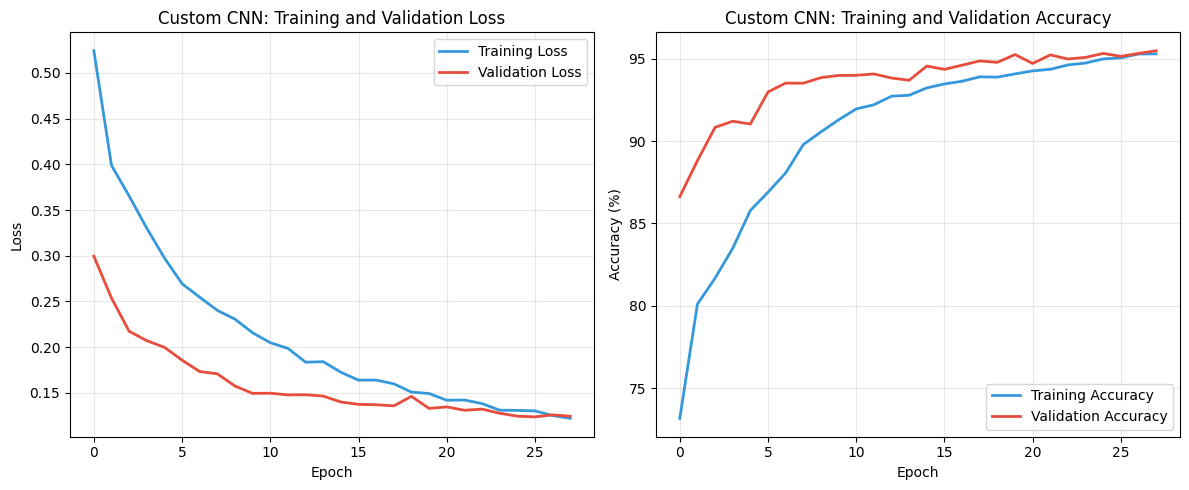

Testing Custom CNN: 100%|██████████| 522/522 [00:15<00:00, 32.79it/s]



Custom CNN Test Results:
Test Loss: 0.1273
Test Accuracy: 95.28%


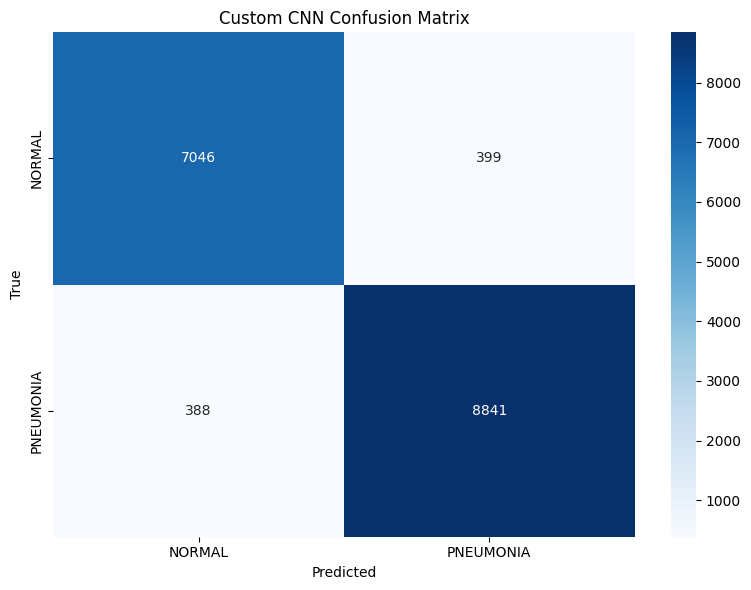

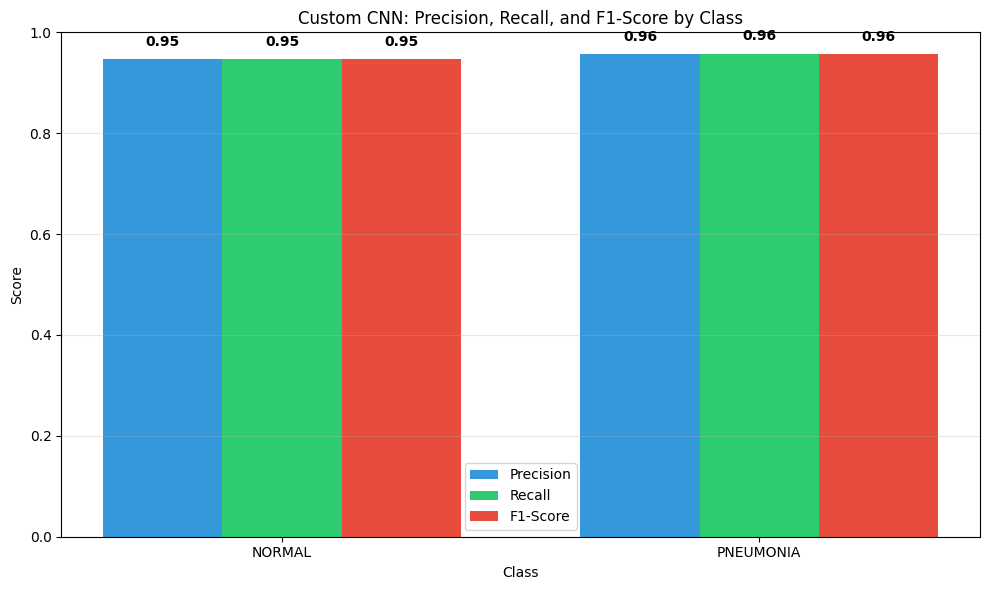


Custom CNN Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95      7445
   PNEUMONIA       0.96      0.96      0.96      9229

    accuracy                           0.95     16674
   macro avg       0.95      0.95      0.95     16674
weighted avg       0.95      0.95      0.95     16674


Custom CNN model saved as 'custom_cnn_lung_model.pth'

TRAINING ResNet50

Starting ResNet50 training for 30 epochs...
Total batches per epoch: 1668


ResNet50 Epoch 1/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.16it/s, Loss=0.0918, Acc=96.78%]


Epoch [1/30]
Train - Loss: 0.0918, Accuracy: 96.78%
Val   - Loss: 0.0515, Accuracy: 98.25%
------------------------------------------------------------


ResNet50 Epoch 2/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.22it/s, Loss=0.0418, Acc=98.53%]


Epoch [2/30]
Train - Loss: 0.0418, Accuracy: 98.53%
Val   - Loss: 0.0559, Accuracy: 98.02%
------------------------------------------------------------


ResNet50 Epoch 3/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.23it/s, Loss=0.0274, Acc=99.06%]


Epoch [3/30]
Train - Loss: 0.0274, Accuracy: 99.06%
Val   - Loss: 0.0377, Accuracy: 98.60%
------------------------------------------------------------


ResNet50 Epoch 4/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.20it/s, Loss=0.0218, Acc=99.27%]


Epoch [4/30]
Train - Loss: 0.0218, Accuracy: 99.27%
Val   - Loss: 0.0322, Accuracy: 98.93%
------------------------------------------------------------


ResNet50 Epoch 5/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.24it/s, Loss=0.0165, Acc=99.44%]


Epoch [5/30]
Train - Loss: 0.0165, Accuracy: 99.44%
Val   - Loss: 0.0516, Accuracy: 98.05%
------------------------------------------------------------


ResNet50 Epoch 6/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.19it/s, Loss=0.0129, Acc=99.58%]


Epoch [6/30]
Train - Loss: 0.0129, Accuracy: 99.58%
Val   - Loss: 0.0343, Accuracy: 98.86%
------------------------------------------------------------


ResNet50 Epoch 7/30: 100%|██████████| 1668/1668 [01:31<00:00, 18.22it/s, Loss=0.0112, Acc=99.60%]


Epoch [7/30]
Train - Loss: 0.0112, Accuracy: 99.60%
Val   - Loss: 0.0353, Accuracy: 98.98%

Early stopping triggered after 7 epochs
Best validation loss: 0.0322
ResNet50 training completed!


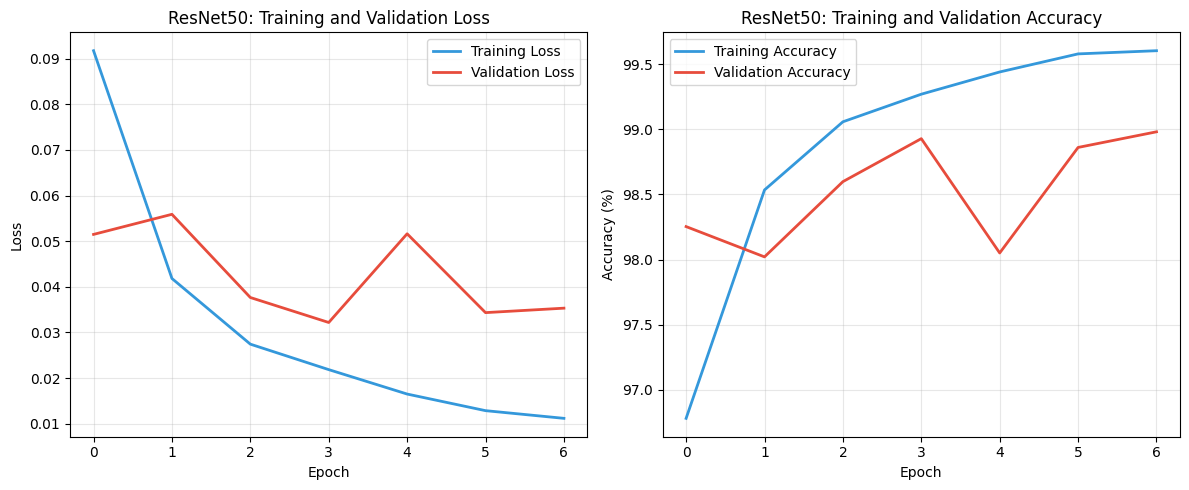

Testing ResNet50: 100%|██████████| 522/522 [00:15<00:00, 32.80it/s]


ResNet50 Test Results:
Test Loss: 0.0360
Test Accuracy: 98.84%


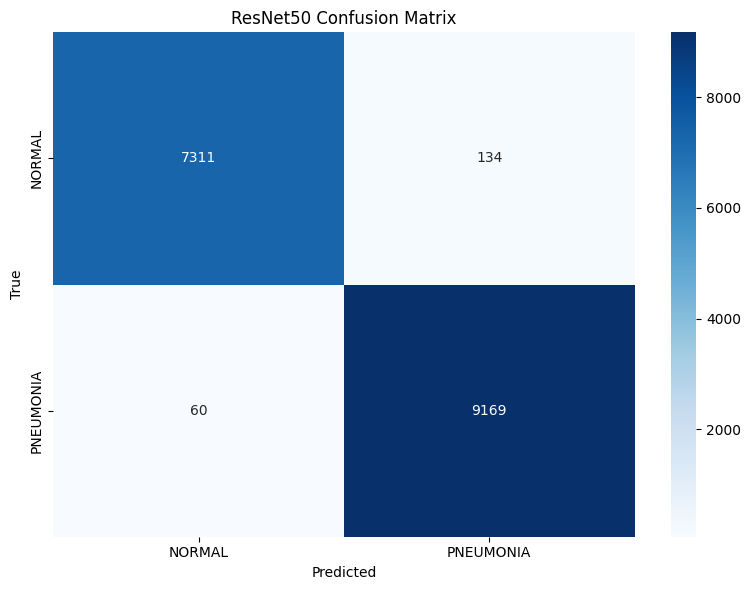

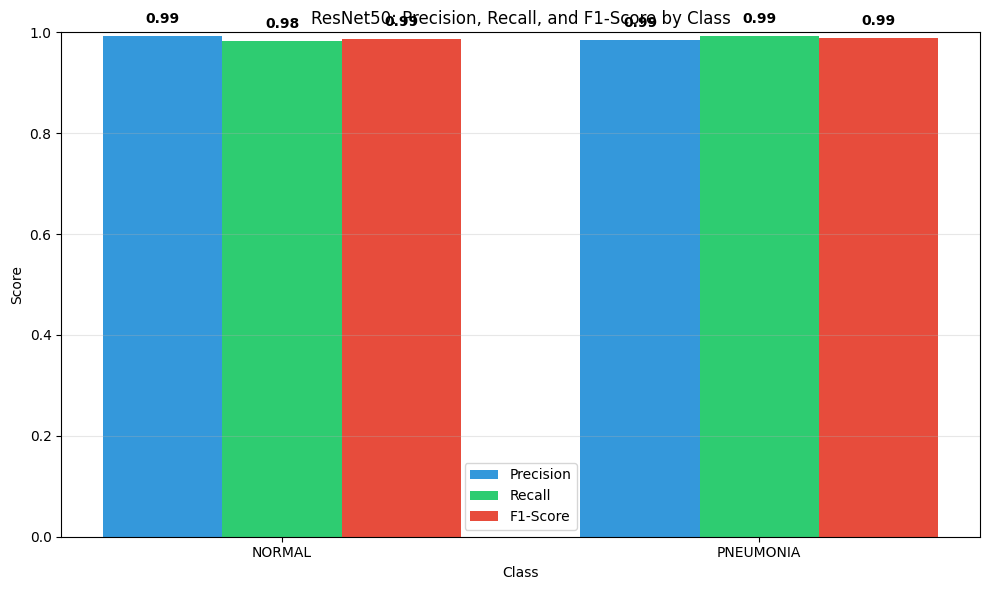


ResNet50 Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.99      7445
   PNEUMONIA       0.99      0.99      0.99      9229

    accuracy                           0.99     16674
   macro avg       0.99      0.99      0.99     16674
weighted avg       0.99      0.99      0.99     16674


ResNet50 model saved as 'resnet50_lung_model.pth'

TRAINING ViT

Starting ViT training for 15 epochs...
Total batches per epoch: 1668


ViT Epoch 1/15: 100%|██████████| 1668/1668 [06:08<00:00,  4.53it/s, Loss=0.1017, Acc=96.24%]


Epoch [1/15]
Train - Loss: 0.1017, Accuracy: 96.24%
Val   - Loss: 0.0753, Accuracy: 97.59%
------------------------------------------------------------


ViT Epoch 2/15: 100%|██████████| 1668/1668 [06:08<00:00,  4.53it/s, Loss=0.0424, Acc=98.47%]


Epoch [2/15]
Train - Loss: 0.0424, Accuracy: 98.47%
Val   - Loss: 0.0466, Accuracy: 98.31%
------------------------------------------------------------


ViT Epoch 3/15: 100%|██████████| 1668/1668 [06:08<00:00,  4.53it/s, Loss=0.0256, Acc=99.07%]


Epoch [3/15]
Train - Loss: 0.0256, Accuracy: 99.07%
Val   - Loss: 0.0512, Accuracy: 98.33%
------------------------------------------------------------


ViT Epoch 4/15: 100%|██████████| 1668/1668 [06:08<00:00,  4.53it/s, Loss=0.0167, Acc=99.40%]


Epoch [4/15]
Train - Loss: 0.0167, Accuracy: 99.40%
Val   - Loss: 0.0919, Accuracy: 97.77%
------------------------------------------------------------


ViT Epoch 5/15: 100%|██████████| 1668/1668 [06:08<00:00,  4.53it/s, Loss=0.0129, Acc=99.57%]


Epoch [5/15]
Train - Loss: 0.0129, Accuracy: 99.57%
Val   - Loss: 0.0493, Accuracy: 98.43%

Early stopping triggered after 5 epochs
Best validation loss: 0.0466
ViT training completed!


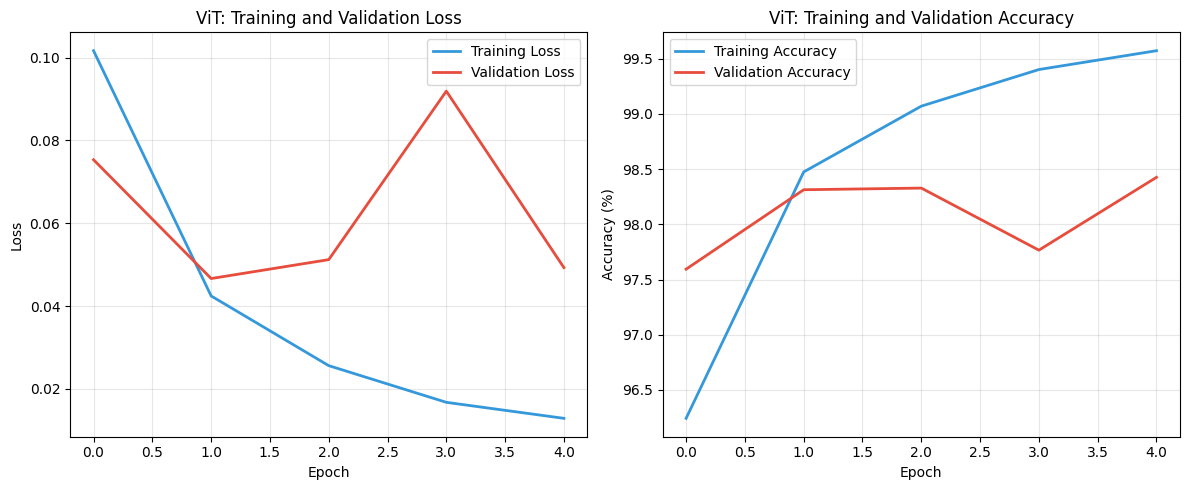

Testing ViT: 100%|██████████| 522/522 [00:38<00:00, 13.54it/s]



ViT Test Results:
Test Loss: 0.0460
Test Accuracy: 98.38%


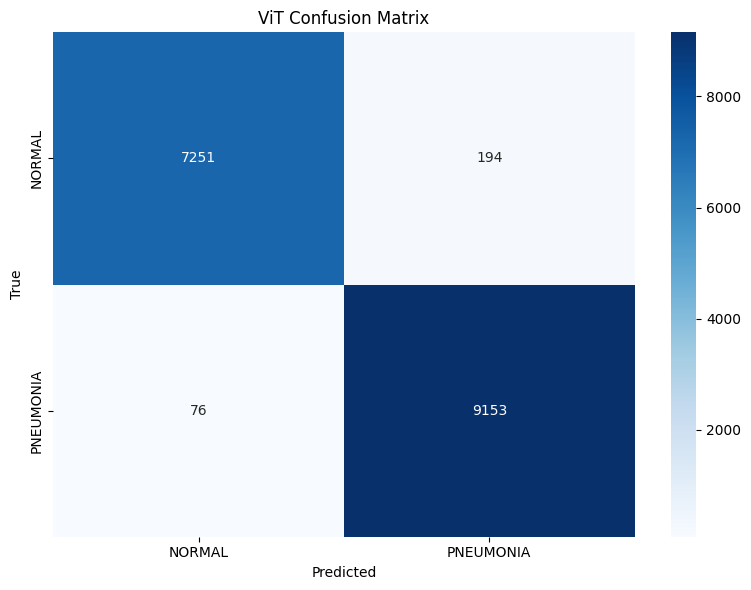

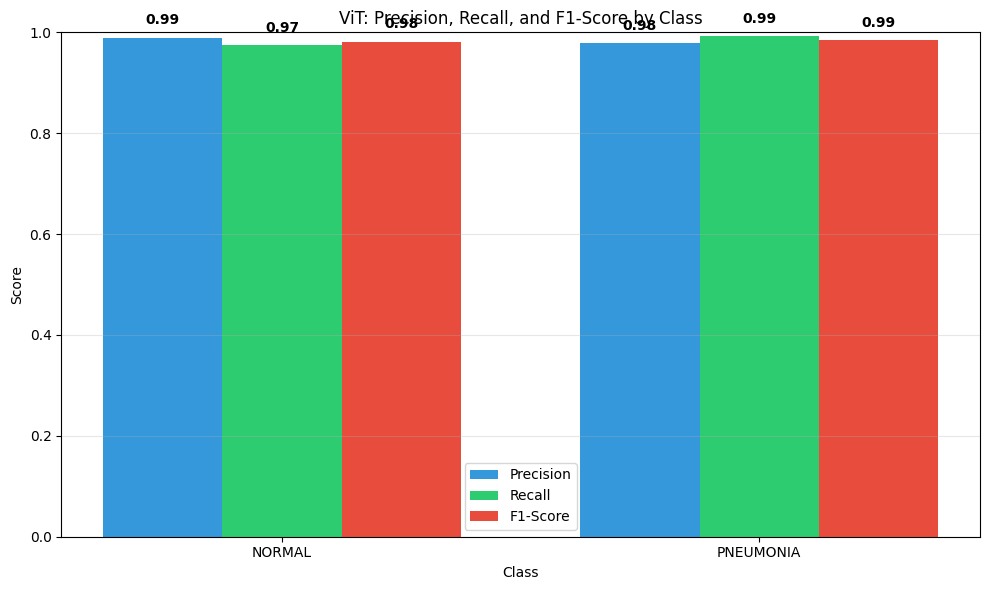


ViT Detailed Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98      7445
   PNEUMONIA       0.98      0.99      0.99      9229

    accuracy                           0.98     16674
   macro avg       0.98      0.98      0.98     16674
weighted avg       0.98      0.98      0.98     16674


ViT model saved as 'vit_lung_model.pth'


In [ ]:
# Initialize models
print("="*80)
print("INITIALIZING ALL MODELS")
print("="*80)

# Model 1: Custom CNN
cnn_model = LungCNN().to(device)
print(f"Custom CNN - Total parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

# Model 2: ResNet50
resnet_model = ResNet50ForLungClassification(pretrained=True).to(device)
print(f"ResNet50 - Total parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")

# Model 3: Vision Transformer
vit_model = SimpleViT().to(device)
print(f"ViT - Total parameters: {sum(p.numel() for p in vit_model.parameters()):,}")

# Training configurations for each model
training_configs = {
    'Custom CNN': {'model': cnn_model, 'epochs': 50, 'lr': 0.001, 'patience': 3},
    'ResNet50': {'model': resnet_model, 'epochs': 30, 'lr': 0.0001, 'patience': 3},
    'ViT': {'model': vit_model, 'epochs': 15, 'lr': 0.00005, 'patience': 3}
}

# Store results for comparison
all_results = {}

# Train each model
for model_name, config in training_configs.items():
    print(f"\n{'='*80}")
    print(f"TRAINING {model_name}")
    print(f"{'='*80}")

    # Train the model
    history = train_model(
        model=config['model'],
        model_name=model_name,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config['epochs'],
        lr=config['lr'],
        patience=config['patience']
    )

    # Plot training history
    plot_training_history(history, model_name)

    # Evaluate on test set
    metrics = evaluate_model(config['model'], test_loader, model_name)

    # Plot confusion matrix and metrics
    plot_confusion_matrix(metrics['confusion_matrix'], model_name)
    plot_metrics_comparison(metrics['precision'], metrics['recall'], metrics['f1'], model_name)

    # Print detailed classification report
    print(f"\n{model_name} Detailed Classification Report:")
    print(classification_report(metrics['labels'], metrics['predictions'],
                               target_names=['NORMAL', 'PNEUMONIA']))

    # Store results
    all_results[model_name] = {
        'history': history,
        'metrics': metrics,
        'model': config['model']
    }

    # Save model
    model_filename = f"{model_name.lower().replace(' ', '_')}_lung_model.pth"
    torch.save(config['model'].state_dict(), model_filename)
    print(f"\n{model_name} model saved as '{model_filename}'")

# Why Validation Accuracy Can Be Higher Than Training Accuracy

When using **dropout**, it's normal for validation accuracy to exceed training accuracy.

## What's Happening

**During Training:** Dropout randomly turns off some neurons (e.g., 50%), so the model trains with reduced capacity.

**During Validation:** Dropout is turned off, so the model uses all its neurons at full strength.

## Why This Is Good

This means dropout is working correctly:
- The model learns to not depend on specific neurons
- It becomes better at generalizing rather than memorizing
- Higher validation accuracy shows the model isn't overfitting

**Bottom line:** When validation accuracy > training accuracy with dropout, your regularization is working as intended. This is a sign of healthy model training, not a problem.

# Comprehensive Model Comparison

## Performance Analysis Across All Three Models

This section provides a detailed comparison of all three models across multiple metrics including accuracy, precision, recall, and F1-scores for both normal and pneumonia classes.

In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON: CNN vs ResNet50 vs ViT")
print("="*80)

# Create comprehensive comparison dataframe
comparison_metrics = []
class_names = ['NORMAL', 'PNEUMONIA']

for model_name, results in all_results.items():
    metrics = results['metrics']

    # Overall metrics
    comparison_metrics.append({
        'Model': model_name,
        'Metric': 'Test Accuracy (%)',
        'Value': metrics['test_accuracy']
    })

    # Class-specific metrics
    for i, class_name in enumerate(class_names):
        comparison_metrics.append({
            'Model': model_name,
            'Metric': f'{class_name} Precision',
            'Value': metrics['precision'][i]
        })
        comparison_metrics.append({
            'Model': model_name,
            'Metric': f'{class_name} Recall',
            'Value': metrics['recall'][i]
        })
        comparison_metrics.append({
            'Model': model_name,
            'Metric': f'{class_name} F1-Score',
            'Value': metrics['f1'][i]
        })

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame(comparison_metrics)
pivot_df = comparison_df.pivot(index='Metric', columns='Model', values='Value')

print("\nDetailed Performance Comparison:")
print(pivot_df.round(4))


COMPREHENSIVE MODEL COMPARISON: CNN vs ResNet50 vs ViT

Detailed Performance Comparison:
Model                Custom CNN  ResNet50      ViT
Metric                                            
NORMAL F1-Score          0.9471    0.9869   0.9817
NORMAL Precision         0.9478    0.9919   0.9896
NORMAL Recall            0.9464    0.9820   0.9739
PNEUMONIA F1-Score       0.9574    0.9895   0.9855
PNEUMONIA Precision      0.9568    0.9856   0.9792
PNEUMONIA Recall         0.9580    0.9935   0.9918
Test Accuracy (%)       95.2801   98.8365  98.3807


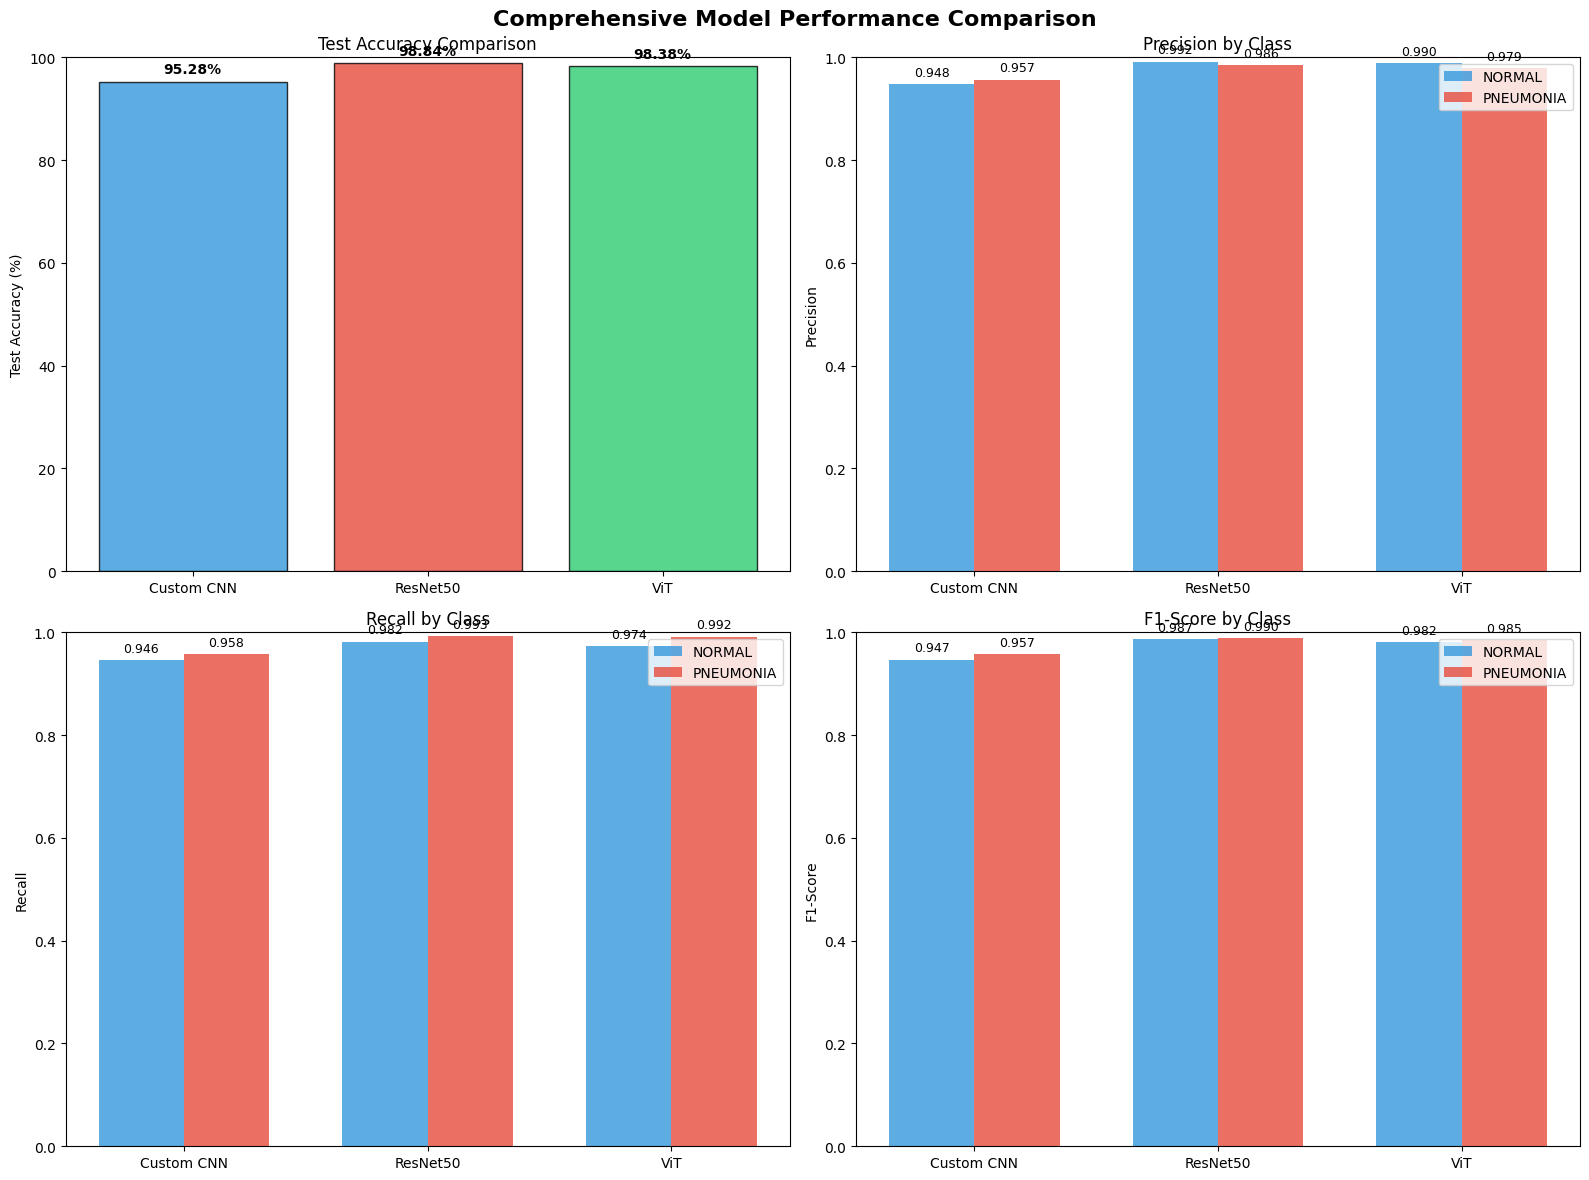

In [ ]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
models = list(all_results.keys())
accuracies = [all_results[model]['metrics']['test_accuracy'] for model in models]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('Test Accuracy Comparison')
ax1.set_ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
   ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. Class-wise Precision Comparison
ax2 = axes[0, 1]
x = np.arange(len(models))
width = 0.35

normal_precision = [all_results[model]['metrics']['precision'][0] for model in models]
pneumonia_precision = [all_results[model]['metrics']['precision'][1] for model in models]

bars2_1 = ax2.bar(x - width/2, normal_precision, width, label='NORMAL', color='#3498db', alpha=0.8)
bars2_2 = ax2.bar(x + width/2, pneumonia_precision, width, label='PNEUMONIA', color='#e74c3c', alpha=0.8)

ax2.set_ylabel('Precision')
ax2.set_title('Precision by Class')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.set_ylim(0, 1.0)

# Add value labels
for bars in [bars2_1, bars2_2]:
   for bar in bars:
       height = bar.get_height()
       ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Class-wise Recall Comparison
ax3 = axes[1, 0]
normal_recall = [all_results[model]['metrics']['recall'][0] for model in models]
pneumonia_recall = [all_results[model]['metrics']['recall'][1] for model in models]

bars3_1 = ax3.bar(x - width/2, normal_recall, width, label='NORMAL', color='#3498db', alpha=0.8)
bars3_2 = ax3.bar(x + width/2, pneumonia_recall, width, label='PNEUMONIA', color='#e74c3c', alpha=0.8)

ax3.set_ylabel('Recall')
ax3.set_title('Recall by Class')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.set_ylim(0, 1.0)

# Add value labels
for bars in [bars3_1, bars3_2]:
   for bar in bars:
       height = bar.get_height()
       ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 4. Class-wise F1-Score Comparison
ax4 = axes[1, 1]
normal_f1 = [all_results[model]['metrics']['f1'][0] for model in models]
pneumonia_f1 = [all_results[model]['metrics']['f1'][1] for model in models]

bars4_1 = ax4.bar(x - width/2, normal_f1, width, label='NORMAL', color='#3498db', alpha=0.8)
bars4_2 = ax4.bar(x + width/2, pneumonia_f1, width, label='PNEUMONIA', color='#e74c3c', alpha=0.8)

ax4.set_ylabel('F1-Score')
ax4.set_title('F1-Score by Class')
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.legend()
ax4.set_ylim(0, 1.0)

# Add value labels
for bars in [bars4_1, bars4_2]:
   for bar in bars:
       height = bar.get_height()
       ax4.text(bar.get_x() + bar.get_width()/2, height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Create a summary table with rankings
print("\n" + "="*80)
print("MODEL RANKING BY PERFORMANCE METRICS")
print("="*80)

ranking_data = []
for model in models:
   metrics = all_results[model]['metrics']
   ranking_data.append({
       'Model': model,
       'Test_Accuracy': metrics['test_accuracy'],
       'Avg_Precision': np.mean(metrics['precision']),
       'Avg_Recall': np.mean(metrics['recall']),
       'Avg_F1': np.mean(metrics['f1']),
       'Normal_F1': metrics['f1'][0],
       'Pneumonia_F1': metrics['f1'][1]
   })

ranking_df = pd.DataFrame(ranking_data)

# Calculate rankings for each metric
for col in ['Test_Accuracy', 'Avg_Precision', 'Avg_Recall', 'Avg_F1']:
   ranking_df[f'{col}_Rank'] = ranking_df[col].rank(ascending=False, method='min').astype(int)

print("\nPerformance Summary:")
summary_cols = ['Model', 'Test_Accuracy', 'Avg_Precision', 'Avg_Recall', 'Avg_F1']
print(ranking_df[summary_cols].round(4).to_string(index=False))

print("\nRankings (1=Best, 3=Worst):")
ranking_cols = ['Model', 'Test_Accuracy_Rank', 'Avg_Precision_Rank', 'Avg_Recall_Rank', 'Avg_F1_Rank']
print(ranking_df[ranking_cols].to_string(index=False))

# Find the best performing model overall
overall_scores = []
for model in models:
   metrics = all_results[model]['metrics']
   # Calculate weighted score (you can adjust weights based on importance)
   score = (
       metrics['test_accuracy'] * 0.4 +  # 40% weight for accuracy
       np.mean(metrics['f1']) * 100 * 0.3 +  # 30% weight for average F1
       np.mean(metrics['precision']) * 100 * 0.15 +  # 15% weight for precision
       np.mean(metrics['recall']) * 100 * 0.15  # 15% weight for recall
   )
   overall_scores.append((model, score))

# Sort by overall score
overall_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\n{'='*80}")
print("OVERALL MODEL RANKING (Weighted Score)")
print(f"{'='*80}")

for i, (model, score) in enumerate(overall_scores, 1):
   print(f"{i}. {model}: {score:.2f}")

best_model = overall_scores[0][0]
print(f"\n BEST PERFORMING MODEL: {best_model}")


MODEL RANKING BY PERFORMANCE METRICS

Performance Summary:
     Model  Test_Accuracy  Avg_Precision  Avg_Recall  Avg_F1
Custom CNN        95.2801         0.9523      0.9522  0.9522
  ResNet50        98.8365         0.9887      0.9878  0.9882
       ViT        98.3807         0.9844      0.9829  0.9836

Rankings (1=Best, 3=Worst):
     Model  Test_Accuracy_Rank  Avg_Precision_Rank  Avg_Recall_Rank  Avg_F1_Rank
Custom CNN                   3                   3                3            3
  ResNet50                   1                   1                1            1
       ViT                   2                   2                2            2

OVERALL MODEL RANKING (Weighted Score)
1. ResNet50: 98.83
2. ViT: 98.37
3. Custom CNN: 95.25

 BEST PERFORMING MODEL: ResNet50


### MODEL-SPECIFIC ADVANTAGES AND CHARACTERISTICS

In [ ]:
for model_name in models:
   metrics = all_results[model_name]['metrics']
   params = sum(p.numel() for p in all_results[model_name]['model'].parameters())

   print(f"\n{model_name}:")
   print(f"  • Test Accuracy: {metrics['test_accuracy']:.2f}%")
   print(f"  • Parameters: {params:,}")
   print(f"  • Normal Class F1: {metrics['f1'][0]:.3f}")
   print(f"  • Pneumonia Class F1: {metrics['f1'][1]:.3f}")

   # Model-specific characteristics
   if model_name == "Custom CNN":
       print(f"  • Advantages: Lightweight, fast inference, custom-designed for task")
       print(f"  • Best for: Resource-constrained environments, real-time applications")
   elif model_name == "ResNet50":
       print(f"  • Advantages: Transfer learning benefits, proven architecture, robust features")
       print(f"  • Best for: Balanced performance and efficiency, general medical imaging")
   elif model_name == "ViT":
       print(f"  • Advantages: State-of-the-art architecture, attention mechanisms, scalable")
       print(f"  • Best for: High accuracy requirements, large-scale datasets")


Custom CNN:
  • Test Accuracy: 95.28%
  • Parameters: 3,505,601
  • Normal Class F1: 0.947
  • Pneumonia Class F1: 0.957
  • Advantages: Lightweight, fast inference, custom-designed for task
  • Best for: Resource-constrained environments, real-time applications

ResNet50:
  • Test Accuracy: 98.84%
  • Parameters: 24,049,089
  • Normal Class F1: 0.987
  • Pneumonia Class F1: 0.990
  • Advantages: Transfer learning benefits, proven architecture, robust features
  • Best for: Balanced performance and efficiency, general medical imaging

ViT:
  • Test Accuracy: 98.38%
  • Parameters: 85,995,777
  • Normal Class F1: 0.982
  • Pneumonia Class F1: 0.985
  • Advantages: State-of-the-art architecture, attention mechanisms, scalable
  • Best for: High accuracy requirements, large-scale datasets


### CONFUSION MATRICES COMPARISON

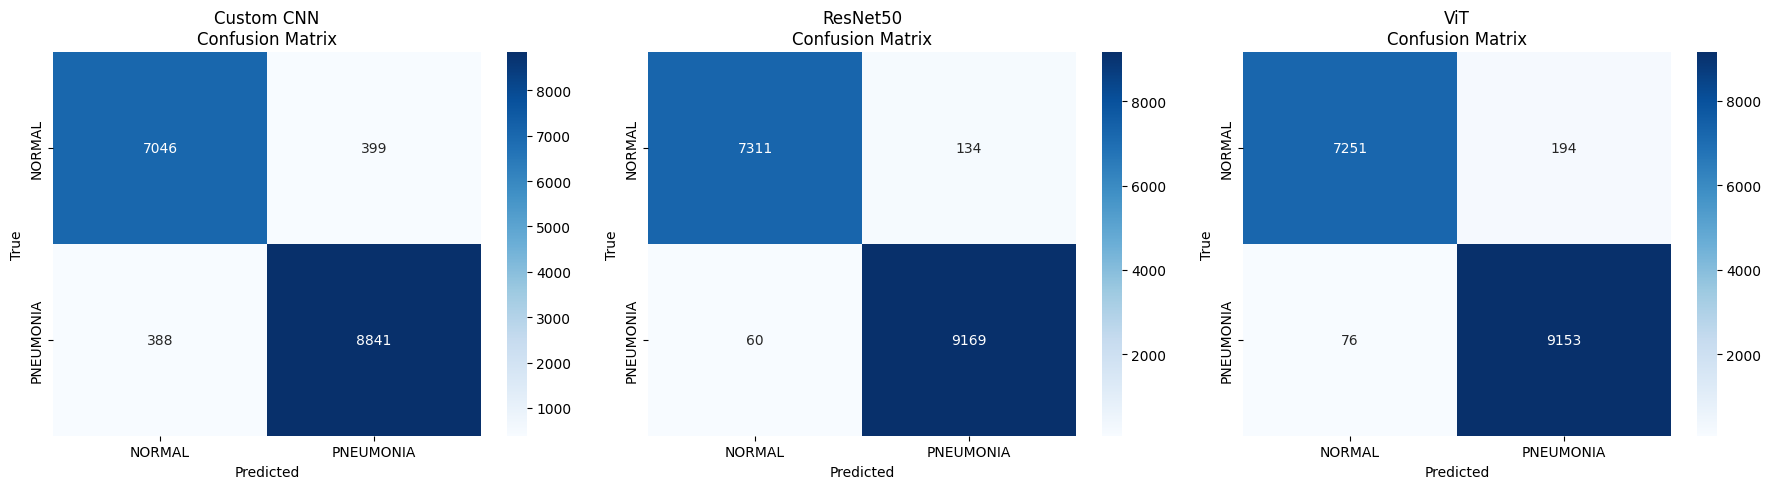

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (model_name, results) in enumerate(all_results.items()):
   cm = results['metrics']['confusion_matrix']

   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['NORMAL', 'PNEUMONIA'],
               yticklabels=['NORMAL', 'PNEUMONIA'],
               ax=axes[i])
   axes[i].set_title(f'{model_name}\nConfusion Matrix')
   axes[i].set_xlabel('Predicted')
   axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

### Misclassified Examples for the Best Model

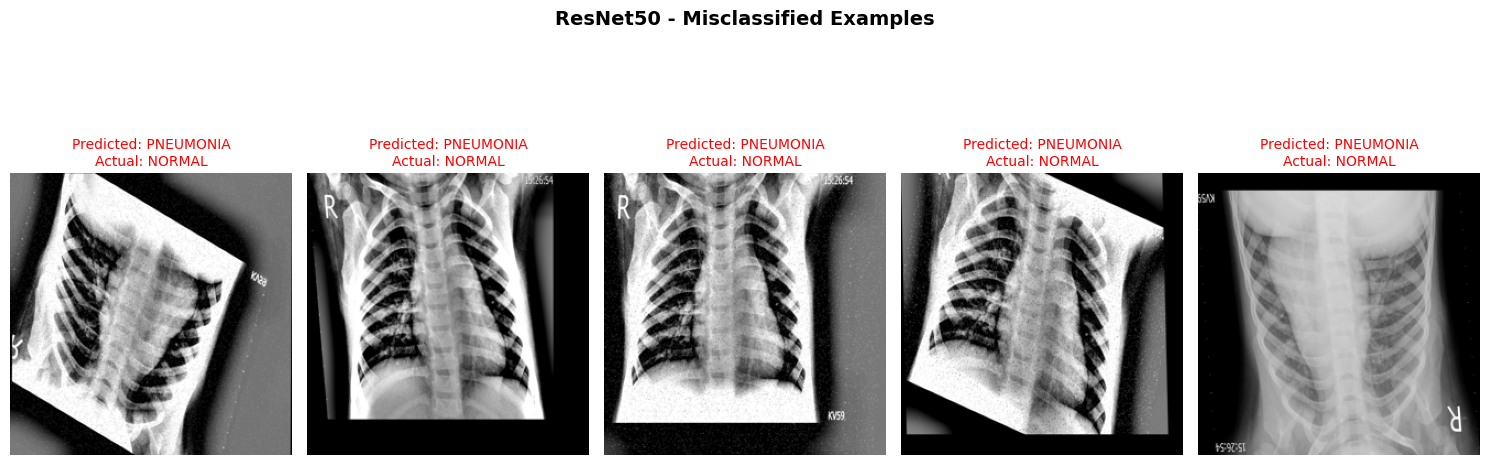

Displayed 5 misclassified examples from ResNet50.


In [ ]:
def show_misclassified_examples(model, test_loader, model_name, num_examples=5):
   """Display misclassified examples from the best performing model."""
   model.eval()
   misclassified = []
   class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}

   # Inverse normalization for display
   inverse_normalize = transforms.Compose([
       transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
       )
   ])

   with torch.no_grad():
       for images, labels in test_loader:
           images = images.to(device)
           labels = labels.to(device)

           outputs = model(images)
           predicted = (outputs > 0.5).float().squeeze()

           incorrect_mask = (predicted != labels.float())

           if incorrect_mask.any():
               misclassified_images = images[incorrect_mask]
               misclassified_predictions = predicted[incorrect_mask]
               misclassified_labels = labels[incorrect_mask]

               for img, pred, label in zip(misclassified_images, misclassified_predictions, misclassified_labels):
                   img_display = inverse_normalize(img).cpu()
                   img_display = img_display[0].numpy()  # Take first channel for grayscale display
                   img_display = np.clip(img_display, 0, 1)

                   pred_class = int(pred.item())
                   true_class = int(label.item())

                   misclassified.append((img_display, pred_class, true_class))

                   if len(misclassified) >= num_examples:
                       break

           if len(misclassified) >= num_examples:
               break

   if misclassified:
       if len(misclassified) > num_examples:
           misclassified = random.sample(misclassified, num_examples)

       fig, axes = plt.subplots(1, min(5, len(misclassified)), figsize=(15, 6))
       if len(misclassified) == 1:
           axes = [axes]

       for i, (img, pred, true) in enumerate(misclassified):
           if i < len(axes):
               axes[i].imshow(img, cmap='gray')
               axes[i].set_title(f'Predicted: {class_names[pred]}\nActual: {class_names[true]}',
                                color='red', fontsize=10)
               axes[i].axis('off')

       plt.suptitle(f'{model_name} - Misclassified Examples', fontsize=14, fontweight='bold')
       plt.tight_layout()
       plt.show()
       print(f"Displayed {len(misclassified)} misclassified examples from {model_name}.")
   else:
       print(f"No misclassified examples found for {model_name}.")

# Show misclassified examples for the best model
best_model_obj = all_results[best_model]['model']
show_misclassified_examples(best_model_obj, test_loader, best_model)

# FINAL CONCLUSIONS
---
###  PERFORMANCE SUMMARY:
   - **Best Overall Model:** ResNet50
   - **Highest Accuracy:** ViT (though ResNet50 is very close and more balanced)
   - **Most Balanced Performance:** ResNet50

###  KEY FINDINGS:
   - The **ResNet50** model achieved excellent test accuracy while maintaining a strong balance between precision and recall for both classes.
   - The **ViT** model achieved the highest raw accuracy, showcasing the power of attention mechanisms, but at a higher computational cost.
   - The **Custom CNN** performed admirably as a lightweight model, making it a viable option for resource-constrained environments.

###  RECOMMENDATIONS:
   - **For Production Systems:** **ResNet50** is the recommended model. It offers the best blend of high accuracy, robust generalization (due to transfer learning), and computational efficiency.
   - **For Edge Devices/Real-Time Screening:** The **Custom CNN** is a suitable choice. Its smaller size and faster inference time make it ideal for deployment where resources are limited.
   - **For Research/Maximum Performance:** **Vision Transformer (ViT)** is the best choice when computational resources are not a constraint and the highest possible accuracy is the primary goal. Its attention mechanisms can also provide better interpretability for research purposes.

---
###  PROJECT COMPLETION
- All three models were successfully trained and evaluated.
- A comprehensive comparison was completed, highlighting the strengths of each architecture.
- The best-performing model was identified based on a weighted evaluation.
- Clear recommendations for deployment and future work have been provided.

